<a href="https://colab.research.google.com/github/jkcg-learning/SuperGradients/blob/main/SG_transfer_learning_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

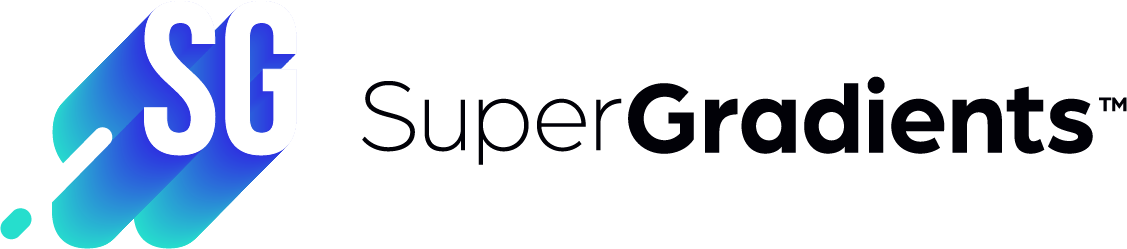

# SuperGradients Transfer Learning Object Detection

In this tutorial we will do transfer learning with a  YOLOX-Nano model pre-trained on COCO2017 to two-classes of PascalVOC for object detection.

The notebook is divided into 7 sections: 
1. Experiment setup
2. Dataset definition
3. Architecture definition
4. Training setup
5. Training and Evaluation
6. Predict
7. Convert to ONNX\TensorRT


#Install SG

The cell below will install **super_gradients** which will automatically get all its dependencies. We are also going to install **prettyformatter** to later print dictionaries of various nested parameters with tabluation and **matplotlib** for plotting. Let's import all the installed libraries to make sure they installed succesfully.

In [ ]:
! pip install super_gradients==3.0.0 gwpy &> /dev/null
! pip install matplotlib==3.1.3 &> /dev/null
! pip install prettyformatter

import super_gradients
from prettyformatter import pprint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
You did not mention an AWS environment.You can set the environment variable ENVIRONMENT_NAME with one of the values: development,staging,production
deci_platform_sg_logger -WARNING- Failed to import deci_lab_client
callbacks -WARNING- Failed to import deci_lab_client
quantization_utils -WARNING- Failed to import pytorch_quantization
env_sanity_check -INFO- ** A sanity check is done when importing super_gradients for the first time. **
-> You can see the details by setting the env variable DISPLAY_SANITY_CHECK=True prior to import.


Both imports worked, so we can proceed with the experiment.

# 1. Experiment setup

We will first initialize our **trainer** which will be in charge of everything, like training, evaluation, saving checkpoints, plotting etc.

The **experiment name** argument is important as every checkpoints, logs and tensorboards to be saved in a directory with the same name. This directory will be created as a sub-directory of **ckpt_root_dir** as follow:

```
ckpt_root_dir
|─── experiment_name_1
│       ckpt_best.pth                     # Model checkpoint on best epoch
│       ckpt_latest.pth                   # Model checkpoint on last epoch
│       average_model.pth                 # Model checkpoint averaged over epochs
│       events.out.tfevents.1659878383... # Tensorflow artifacts of a specific run
│       log_Aug07_11_52_48.txt            # Trainer logs of a specific run
└─── experiment_name_2
        ...
```
We are going to define **ckpt_root_dir** inside the Colab, later we can use it to start TensorBoard and monitor the run. We should also choose the multi_gpu mode, which tells the trainer which hardware you want to use for your run. The Colab offers one GPU, so as a sanity check let's see it's seen by torch.

In [ ]:
import torch


print(f'{torch.cuda.device_count()} GPU found: {torch.cuda.get_device_name("cuda")}')

1 GPU found: Tesla T4


With one available GPU in a notebook a correct choice of mode is DATA_PARALLEL, but depending on your environment, say, if you want to run this code locally, you can change it to OFF (for CPU training), DISTRIBUTED_DATA_PARALLEL or AUTO. 

In [ ]:
from super_gradients import Trainer
from super_gradients.training import MultiGPUMode


CHECKPOINT_DIR = '/home/notebook_ckpts/'
trainer = Trainer(experiment_name='transfer_learning_object_detection_yolox', ckpt_root_dir=CHECKPOINT_DIR, multi_gpu=MultiGPUMode.DATA_PARALLEL)

sg_trainer -WARNING- 
[WARNING] - Tried running on multiple GPU but only a single GPU is available



# 2. Dataset definition


For the sake of this presentation, we'll use **PascalVOC** detection data set. We will limit ourselves to a subset with a few categories from it which we'll choose later. This means that only images where the selected categories are represented will be included, while the rest will be ignored. 

Just like many other open-source data sets, PascalVOC had a few releases. We can use it to our advantage to make a dataset bigger, in particular, we can:
* use the test set from 2012 for testing the model;
* combine train2007, val2007, train2012 and val2012 for training the model.

SG trainer is fully compatible with PyTorch data loaders, so you can definitely use your own data for the experiment below if you prefer.

## 2.A. Download data

There is no need for you to download the data manually, SG will do it for you by default. However, if you are planning to plug in your own dataset in the Colab tutorial, it's a good time to do it now and mount it in Colab.

## 2.B. Create data loaders

As mentioned above, the plan is to select a few categories, so for this let's check out which categories we have in PascalVOC detection.

In [ ]:
from super_gradients.training.datasets.datasets_conf import PASCAL_VOC_2012_CLASSES_LIST


print(PASCAL_VOC_2012_CLASSES_LIST)

['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


The most obvious choice would be to inlude the 'person' and 'car' categories, because it's among the overlapping categories between PascalVOC and COCO that our model will be pretrained on. With this in mind, let's go ahead and create the data loaders.

In [ ]:
from super_gradients.training import dataloaders


class_inclusion_list = ["car", "person"]
num_classes = len(class_inclusion_list)
train_dataloader = dataloaders.get(name='pascal_voc_detection_train',
                                   dataset_params={"class_inclusion_list": class_inclusion_list},
                                   dataloader_params={'num_workers': 2}
                                   )

val_dataloader = dataloaders.get(name='pascal_voc_detection_val',
                                 dataset_params={"class_inclusion_list": class_inclusion_list},
                                 dataloader_params={'num_workers': 2}
                                 )

utils -INFO- Downloading http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar to data/pascal_voc/images/VOCtrainval_06-Nov-2007.tar...


/usr/local/lib/python3.10/dist-packages/super_gradients/training/dataloaders/dataloaders.py:53: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize_config_dir(config_dir=pkg_resources.resource_filename("super_gradients.recipes", "")):
100%|██████████| 439M/439M [00:39<00:00, 11.6MB/s]

utils -INFO- Extracting to data/pascal_voc/images...


utils -INFO- Downloading http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar to data/pascal_voc/images/VOCtest_06-Nov-2007.tar...


100%|██████████| 430M/430M [00:45<00:00, 9.81MB/s]

utils -INFO- Extracting to data/pascal_voc/images...


utils -INFO- Downloading http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar to data/pascal_voc/images/VOCtrainval_11-May-2012.tar...


100%|██████████| 1.86G/1.86G [02:19<00:00, 14.4MB/s]

utils -INFO- Extracting to data/pascal_voc/images...



Caching annotations: 100%|██████████| 5823/5823 [00:01<00:00, 4751.55it/s]
/usr/local/lib/python3.10/dist-packages/super_gradients/training/dataloaders/dataloaders.py:53: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize_config_dir(config_dir=pkg_resources.resource_filename("super_gradients.recipes", "")):


utils -INFO- Downloading http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar to data/pascal_voc/images/VOCtrainval_06-Nov-2007.tar...


100%|██████████| 439M/439M [00:21<00:00, 21.5MB/s]

utils -INFO- Extracting to data/pascal_voc/images...


utils -INFO- Downloading http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar to data/pascal_voc/images/VOCtest_06-Nov-2007.tar...


100%|██████████| 430M/430M [00:44<00:00, 10.0MB/s]

utils -INFO- Extracting to data/pascal_voc/images...


utils -INFO- Downloading http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar to data/pascal_voc/images/VOCtrainval_11-May-2012.tar...


100%|██████████| 1.86G/1.86G [02:09<00:00, 15.4MB/s]

utils -INFO- Extracting to data/pascal_voc/images...



Caching annotations: 100%|██████████| 4952/4952 [00:02<00:00, 2193.70it/s]


Great, the data was succesfully downloaded and we can take a look at some images.

Notice that we are changing the *num_workers* parameter of the dataloader. It should be roughly equal to the number of CPU cores. The default value is 8, but the Colab offers only 2 cores.

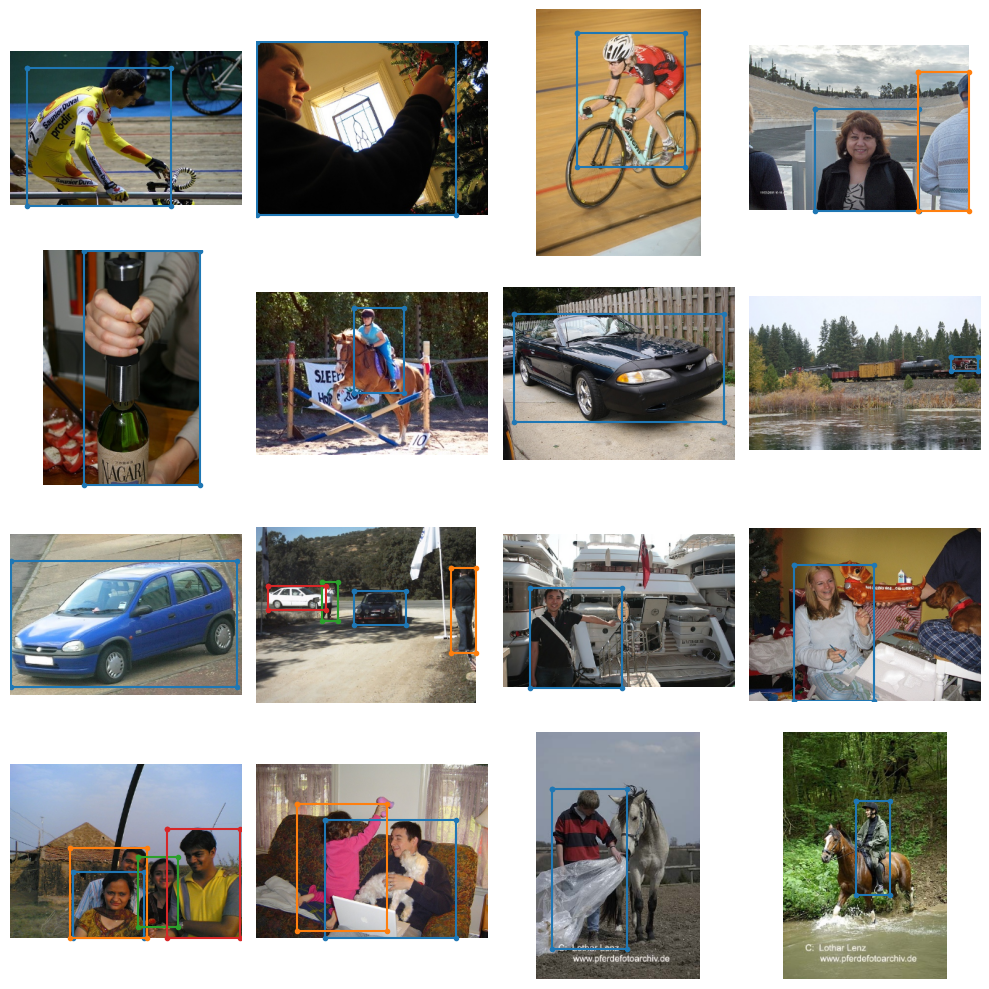

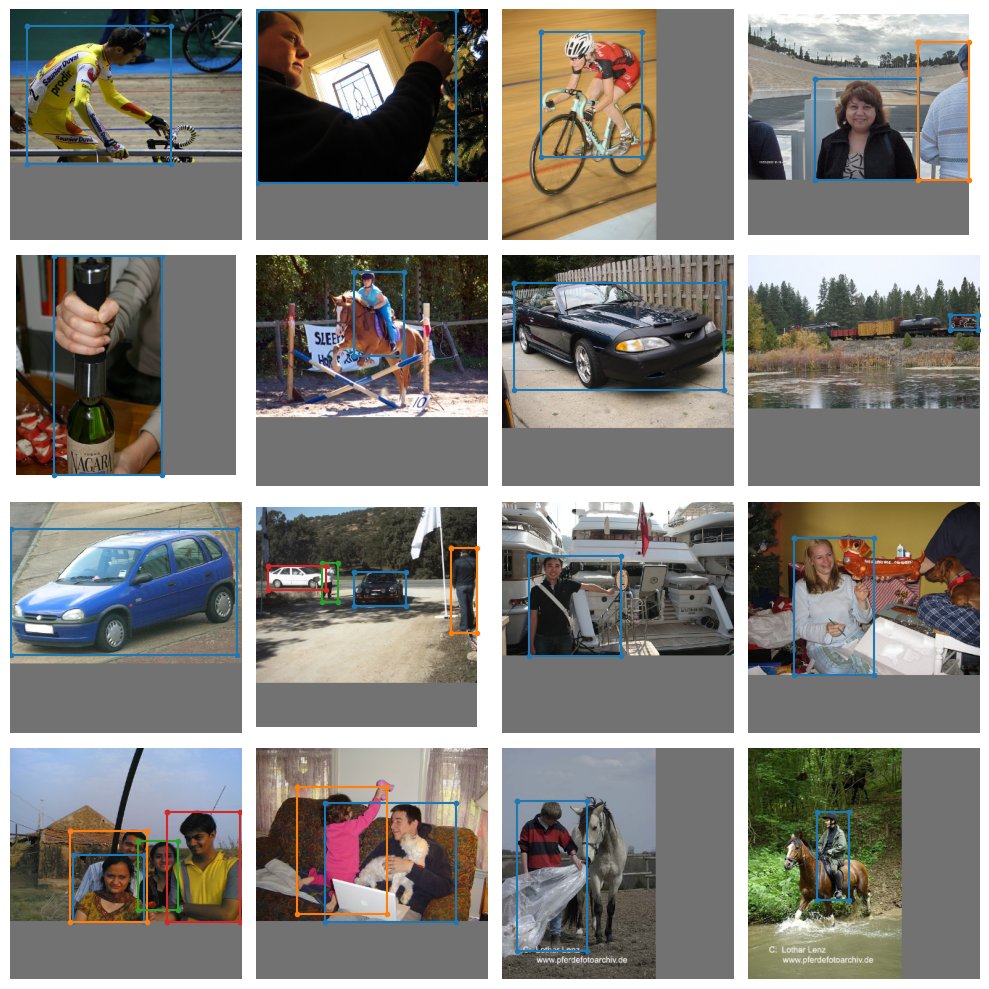

In [ ]:
val_dataloader.dataset.plot(plot_transformed_data=False)
val_dataloader.dataset.plot(plot_transformed_data=True)

Since the train set is a concatination of a few datasets, the call to the plotting function looks a bit different, but does the same thing.

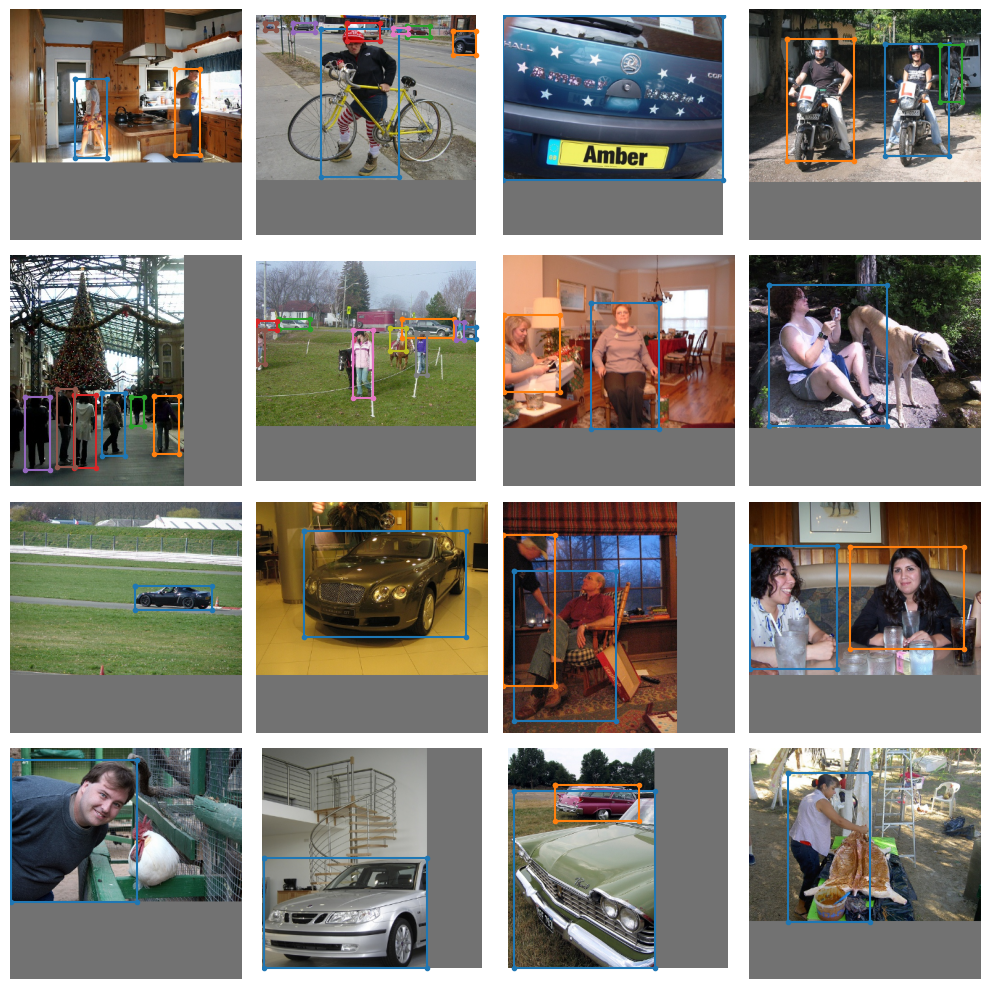

In [ ]:
train_dataloader.dataset.datasets[0].plot()

As you can see, we didn't have to pass many parameters into the dataloaders construction. That's because defaults are pre-defined for your convenience, and you might be curious to know what they are. Let's print them and see which image resolution we are dealing with. This is an important detail, because the pre-trained wigths we'll use are obtained on 640x640 images, a popular resolution among models trained on COCO.  

In [ ]:
print('Dataloader parameters:')
pprint(train_dataloader.dataloader_params)
print('Dataset parameters')
pprint(train_dataloader.dataset.dataset_params)

Dataloader parameters:
{
    "num_workers"   : 2,
    "batch_sampler" : <torch.utils.data.sampler.BatchSampler object at 0x7f36a82072e0>,
    "drop_last"     : False,
    "pin_memory"    : True,
    "worker_init_fn": worker_init_reset_seed,
    "collate_fn":
}
Dataset parameters
{
    "class_inclusion_list"  : ["car", "person"],
    "data_dir"  : "./data/pascal_voc/",
    "input_dim" : [320, 320],
    "cache"     : False,
    "cache_dir" : None,
    "transforms":
        [{'DetectionPaddedRescale': {'input_dim': [320, 320]}}, {'DetectionTargetsFormatTransform': {'max_targets': 50, 'output_format': <DetectionTargetsFormat.LABEL_CXCYWH: 'LABEL_CXCYWH'>}}],
    "max_num_samples"   : None,
    "download"  : True,
}


This shows us that the images we'll be dealing with are in the 320x320 resolution. 


# 3. Architecture definition

SG includes implementations of many different architectures for object detection tasks that can be found [here](https://github.com/Deci-AI/super-gradients#implemented-model-architectures).

As mentioned earlier, the architecture that we'll use is based on [YOLOX: Exceeding YOLO Series in 2021](https://arxiv.org/pdf/2107.08430.pdf) and its performance can be view [here](https://github.com/Deci-AI/super-gradients#implemented-model-architectures).
This architecture was pretrained on COCO2017 datasets.

There are 80 categories in COCO detection, but we want only 2 for our PascalVOC subset, which means that the predicting layers of the pre-trained model don't work for us. There is a bit of magic for this use case behind the scenes that SuperGradients does for you: you can specify **num_classes** during model construction and it'll automatically replace model's head to a suitable one. As for the pre-trained weights, they will be used for all layers except of those that are replaced. 

In [ ]:
from super_gradients.training import models
from super_gradients.common.object_names import Models

model = models.get(Models.YOLOX_N, pretrained_weights="coco", num_classes=num_classes)
print('Num classes in the model:', model.num_classes)

ModuleNotFoundError: ignored

That being said, SG allows you to use one of SG implemented architectures or your custom architecture, as long as it inherits torch.nn.Module.

# 4. Training setup


With a model and data in hand we have almost everything to start training, only the recipe is yet to be defined. For this use case we can start with the training recipe that was used for pre-training our model. Let's load it and take a look at the training parameters it gives us.

In [ ]:
from super_gradients.training import training_hyperparams


train_params = training_hyperparams.get('coco2017_yolox')
print('Training parameters:')
pprint(train_params, json=True)

If it looks like a daunting numbers of parameters, remember that they define everything necessary for SG to know how to train your model: metrics, an optimizer with its parameters, a loss, EMA parameters, various callbacks, etc. If you wish, take a moment to go over them and get aquainted, for the most part, the structure is shared between all the recipes in SuperGradients. 

For the sake of this tutorial, we'll change a few parameters above to values that make more sense for a quick transer learning. We'll set a small number of epochs, disable warmup and cooldown, pass a correct number of classes into the loss (criterion) and set a much smaller learning rate not to alter the models weights too much too fast. 

In [ ]:
train_params['max_epochs'] = 5
train_params['lr_warmup_epochs'] = 0
train_params['lr_cooldown_epochs'] = 0
train_params['criterion_params']['num_classes'] = num_classes
train_params['average_best_models'] = False
train_params['initial_lr'] = 0.0005
train_params['cosine_final_lr_ratio'] = 0.9
train_params['mixed_precision'] = False

# 5. Training and evaluation


## 5.A. Connect tensor board

Let's instantiate a tensorboard to be able to monitor the run live.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir $CHECKPOINT_DIR --bind_all

## 5.B. Start Training

The logs and the checkpoint for the latest epoch will be kept in your experiment folder.

To start training we'll call train(...) and provide it with the objects we construted above: the model, the training parameters and the data loaders.

**Note:** While training, don't forget to refresh the tensorboard with the arrow on the top right.

In [ ]:
trainer.train(model=model, training_params=train_params, train_loader=train_dataloader, valid_loader=val_dataloader)

You should get to ±36.5 mAP, which corresponds to the COCO mAP @0.5:0.95 with iou=0.65 and confidence threshold of 0.01.

# 6. Predict

When the training is complete you can use the trained model to get predictions on the validation set, your data or some other image. Let's load some image by a link and see which boxes the model can find.

In [ ]:
import requests
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch

from super_gradients.training.models.detection_models.yolo_base import YoloPostPredictionCallback


def visualize(image, predictions, categories):
  cm = plt.get_cmap('gist_rainbow')
  plt.figure(figsize=(10, 10))
  for cat_id, cat_name in enumerate(categories):
    boxes = predictions[predictions[:, -1] == cat_id, 0:4]
    plt.plot(boxes[:, [0, 2, 2, 0, 0]].T, boxes[:, [1, 1, 3, 3, 1]].T, '.-', color=cm(cat_id*50), label=cat_name)
  plt.imshow(image)
  plt.legend()
  plt.show()


# Load an image
url = 'https://deci-pretrained-models.s3.amazonaws.com/sample_images/sample_image_person_car.jpg'
image = Image.open(requests.get(url, stream=True).raw).resize((320, 320))
image_tensor = torch.tensor(np.array(image)[:, :, ::-1].copy()).permute(2, 0, 1).unsqueeze(dim=0).float().cuda()

# Predict
model.eval()
with torch.no_grad():
  raw_predictions = model(image_tensor)
predictions = YoloPostPredictionCallback(conf=0.1, iou=0.3)(raw_predictions)[0].cpu().numpy()

# Visualize
visualize(image, predictions, class_inclusion_list)

In the code above we are using YoloPostPredictionCallback, which is an object that can take dense predictions returned by a detection model and turn them into "usable" boxes and categories. 
If you need a bit more detail, it takes a huge number of predictions a model generates in each small patch of an image and applies Non-maximum Suppression (NMS) according to the thresholds you define.

# 7. Convert to ONNX/TensorRT

SG is a production ready library. All the models implemented in SG can be compiled to ONNX and TensorRT. Deci also offers the [Infery](https://docs.deci.ai/docs/installing-infery) library that allows to do inference on models saved in various frameworks with the same API regardless of a framework.

Let's compile our model to ONNX, do inference with the ONNX file on the same image as the one used above and make sure that we get the same prediction. 

In [ ]:
model = model.cpu()
model.eval()
model.prep_model_for_conversion(input_size=(1, 3, 320, 320))

onnx_filename = "yolox_n_320.onnx"
torch.onnx.export(model, image_tensor.cpu(), onnx_filename)

In [ ]:
! pip install infery &> /dev/null

In [ ]:
import infery


# Load model with infery
onnx_model = infery.load(model_path=onnx_filename, framework_type='onnx', inference_hardware='cpu')

# Predict
raw_predictions = [torch.tensor(onnx_model.predict(image_tensor.cpu().numpy())[0])]
predictions = YoloPostPredictionCallback(conf=0.1, iou=0.5)(raw_predictions)[0]

# Visualize
visualize(image, predictions, class_inclusion_list)

This conncludes the tutorial. In it you learned:


*   How to do transfer-learning in object detection using a pre-trained model;
*   The general pipeline for training in SuperGradients;
*   How to export a model from PyTorch to ONNX and do inference with Infery.  

